In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/kaggle/input/sales-forecasting/train.csv')

print(df.head())
print(df.info())


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

# Preprocessing

In [4]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

daily_sales = daily_sales.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

print(daily_sales.isnull().sum())


ds    0
y     0
dtype: int64


# Train/Validation Split

In [5]:
split_index = int(len(daily_sales) * 0.9)

train_df = daily_sales.iloc[:split_index]
val_df = daily_sales.iloc[split_index:]

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)


Train shape: (1107, 2)
Validation shape: (123, 2)


# Initialize Prophet model

In [6]:
model = Prophet(
    growth='linear',            
    yearly_seasonality=True,    
    weekly_seasonality=True,   
    daily_seasonality=False   
)


In [7]:
model.fit(train_df)
future = model.make_future_dataframe(periods=len(val_df), freq='D')
forecast = model.predict(future)


17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing


# Evaluate performance

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


val_forecast = forecast[forecast['ds'].isin(val_df['ds'])]

preds = preds.dropna(subset=['y', 'yhat'])

print(preds.isna().sum())

mae = mean_absolute_error(preds['y'], preds['yhat'])
rmse = mean_squared_error(preds['y'], preds['yhat'], squared=False)

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")


y       0
yhat    0
dtype: int64
Validation MAE: 1977.17
Validation RMSE: 2674.36


# Sales forecast

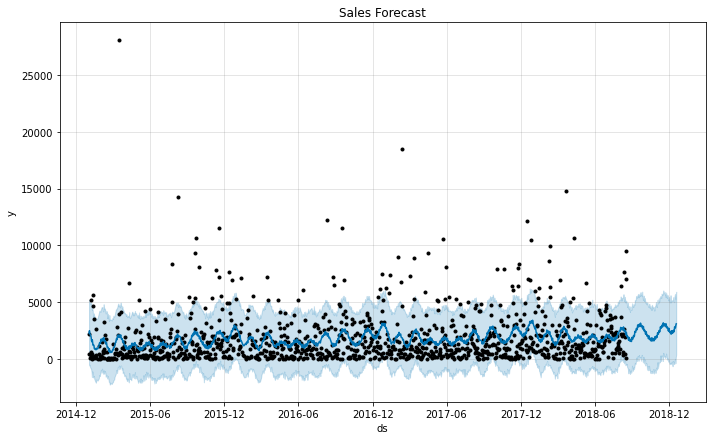

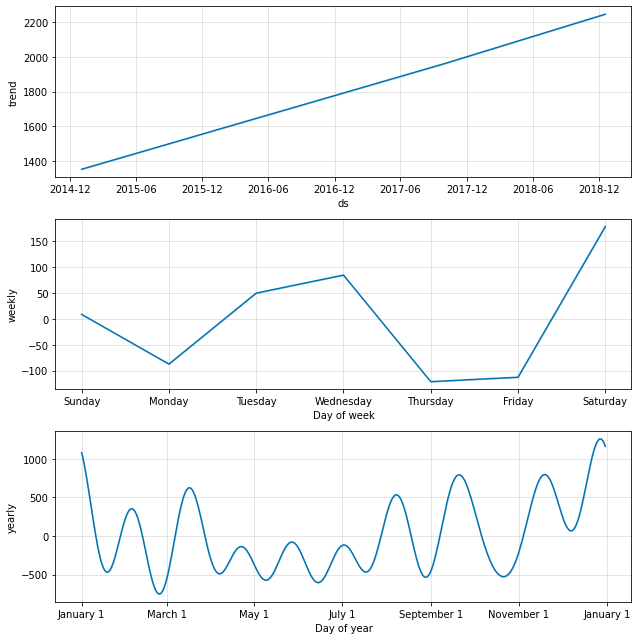

In [10]:
model.plot(forecast)
plt.title("Sales Forecast")
plt.show()

model.plot_components(forecast)
plt.show()


# Forecast vs Actual

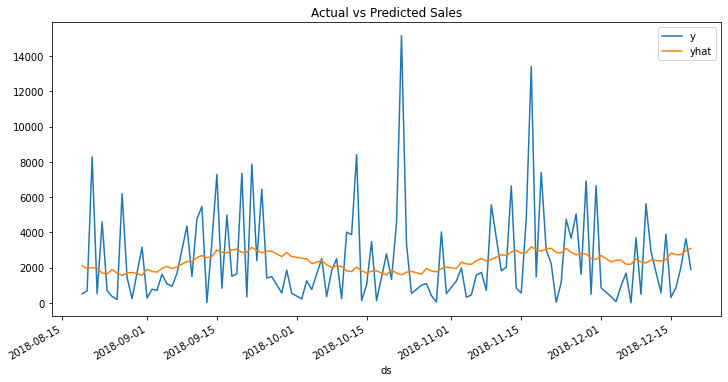

In [13]:
preds[['y', 'yhat']].plot(figsize=(12,6))
plt.title("Actual vs Predicted Sales")
plt.show()


# Residuals

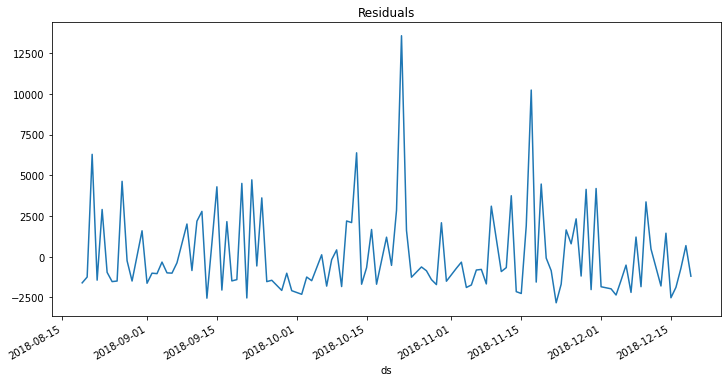

In [14]:
preds['residual'] = preds['y'] - preds['yhat']
preds['residual'].plot(figsize=(12,6), title="Residuals")
plt.show()


# Improved Model Train

In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv('/kaggle/input/sales-forecasting/train.csv')
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96


In [8]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

## Basic Preprocessing

In [12]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

daily_sales = (
    df.groupby('Order Date')['Sales']
    .sum()
    .reset_index()
    .rename(columns={'Order Date':'ds', 'Sales': 'y'})
)

daily_sales['y'] = daily_sales['y'].clip(lower=0)
daily_sales = daily_sales.sort_values('ds').reset_index(drop=True)

print('missing vales:\n', daily_sales.isnull().sum())

daily_sales['y_log'] = np.log1p(daily_sales['y'])


missing vales:
 ds    0
y     0
dtype: int64


## Split

In [13]:
split_index = int(len(daily_sales) * 0.9)
train_df = daily_sales.iloc[:split_index][['ds', 'y_log']]
val_df = daily_sales.iloc[split_index:][['ds', 'y_log']]

print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")


Train shape: (1107, 2)
Validation shape: (123, 2)


In [19]:
train_df = train_df.rename(columns={'y_log': 'y'})
val_df = val_df.rename(columns={'y_log': 'y'})
print(train_df.columns)
print(val_df.columns)

Index(['ds', 'y'], dtype='object')
Index(['ds', 'y'], dtype='object')


## Model

In [20]:
model = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.5,   
    seasonality_prior_scale=10.0,  
    interval_width=0.9,           
)

## Holidays

In [21]:
from prophet.make_holidays import make_holidays_df
holidays = make_holidays_df(year_list = [2015, 2016, 2017, 2018], country = 'US')
model.add_country_holidays(country_name='US')

model.fit(train_df)

14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing


## Future dataframe

In [23]:
future = model.make_future_dataframe(periods = len(val_df), freq = 'D')
forecast = model.predict(future)

## Evaluate

In [25]:
val_forecast = forecast.iloc[-len(val_df):].copy()

val_forecast['yhat_exp'] = np.expm1(val_forecast['yhat'])
val_df['y_exp'] = np.expm1(val_df['y'])

preds = pd.merge(val_df, val_forecast[['ds', 'yhat_exp']], on='ds', how='left')
preds.dropna(inplace=True)

mae = mean_absolute_error(preds['y_exp'], preds['yhat_exp'])
rmse = mean_squared_error(preds['y_exp'], preds['yhat_exp'], squared=False)

print(f"\n Validation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


 Validation Metrics:
MAE:  1780.69
RMSE: 2775.15


## Forecast Plot

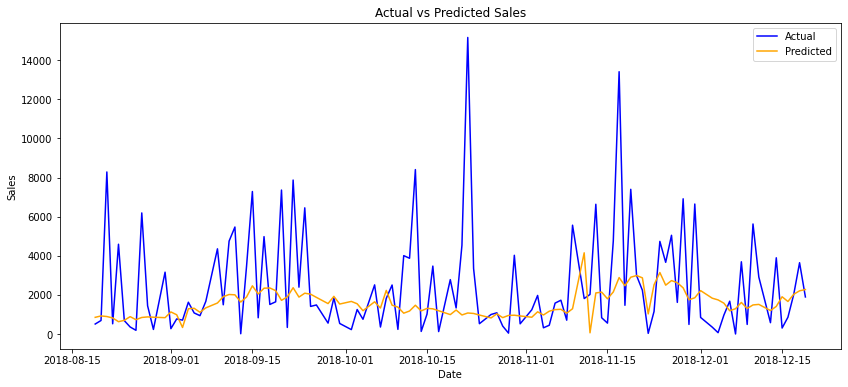

In [26]:
plt.figure(figsize=(14,6))
plt.plot(preds['ds'], preds['y_exp'], label='Actual', color='blue')
plt.plot(preds['ds'], preds['yhat_exp'], label='Predicted', color='orange')
plt.title("Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

## Residuals

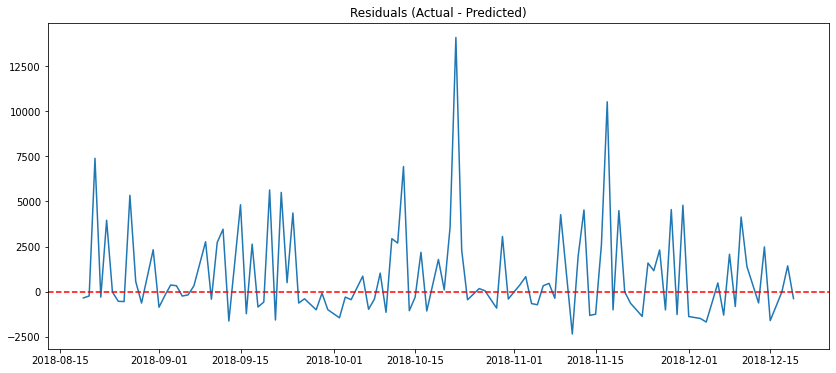

In [27]:
preds['residual'] = preds['y_exp'] - preds['yhat_exp']
plt.figure(figsize=(14,6))
plt.plot(preds['ds'], preds['residual'], label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals (Actual - Predicted)")
plt.show()

## Exploring Hyperparameter Space

In [28]:
import optuna
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

def objective(trial):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.01, 1.0, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 1.0, 20.0, log=True)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.1, 20.0, log=True)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
    ).add_country_holidays(country_name='US')

    model.fit(train_df)

    df_cv = cross_validation(model, initial='720 days', period='180 days', horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv)

    rmse = df_p['rmse'].values[0]
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, n_jobs=-1)

print("Best hyperparameters:")
print(study.best_params)


[I 2025-11-02 14:34:27,708] A new study created in memory with name: no-name-89234f4b-b76c-4de8-906a-b0bc2373ef57
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
14:34:28 - cmdstanpy - INFO - Chain [1] start processing
14:34:28 - cmdstanpy - INFO - Chain [1] done processing
14:34:28 - cmdstanpy - INFO - Chain [1] start processing
14:34:28 - cmdstanpy - INFO - Chain [1] start processing
14:34:28 - cmdstanpy - INFO - Chain [1] start processing
14:34:28 - cmdstanpy - INFO - Chain [1] done processing
14:34:28 - cmdstanpy - INFO - Chain [1] done processing
14:34:28 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstan

Best hyperparameters:
{'changepoint_prior_scale': 0.012547952051378977, 'seasonality_prior_scale': 5.243463121013967, 'holidays_prior_scale': 0.5841760163606908, 'seasonality_mode': 'additive'}


In [30]:
best_params = {
    'changepoint_prior_scale': 0.012547952051378977,
    'seasonality_prior_scale': 5.243463121013967,
    'holidays_prior_scale': 0.5841760163606908,
    'seasonality_mode': 'additive',
}

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    growth='linear',
    **best_params
).add_country_holidays(country_name='US')

model.fit(train_df)

future = model.make_future_dataframe(periods=len(val_df), freq='D')
forecast = model.predict(future)

val_forecast = forecast.iloc[-len(val_df):].copy()
val_forecast['yhat_exp'] = np.expm1(val_forecast['yhat'])
val_df['y_exp'] = np.expm1(val_df['y'])

preds = pd.merge(val_df, val_forecast[['ds', 'yhat_exp']], on='ds', how='left')
preds.dropna(inplace=True)

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(preds['y_exp'], preds['yhat_exp'])
rmse = mean_squared_error(preds['y_exp'], preds['yhat_exp'], squared=False)

print(f"\n Final Tuned Model Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

14:37:13 - cmdstanpy - INFO - Chain [1] start processing
14:37:14 - cmdstanpy - INFO - Chain [1] done processing



 Final Tuned Model Performance:
MAE:  1766.01
RMSE: 2805.10


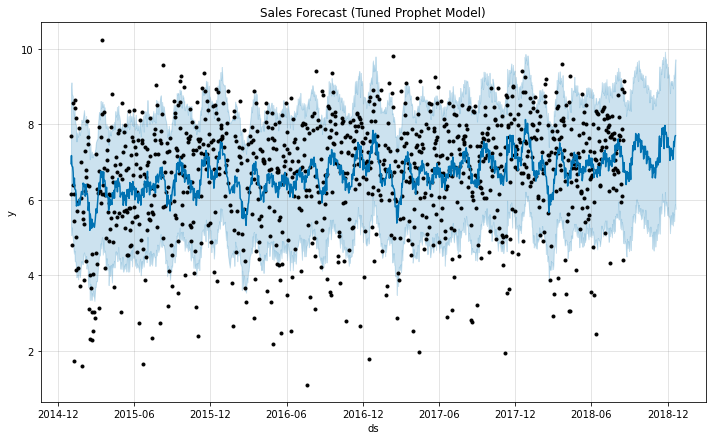

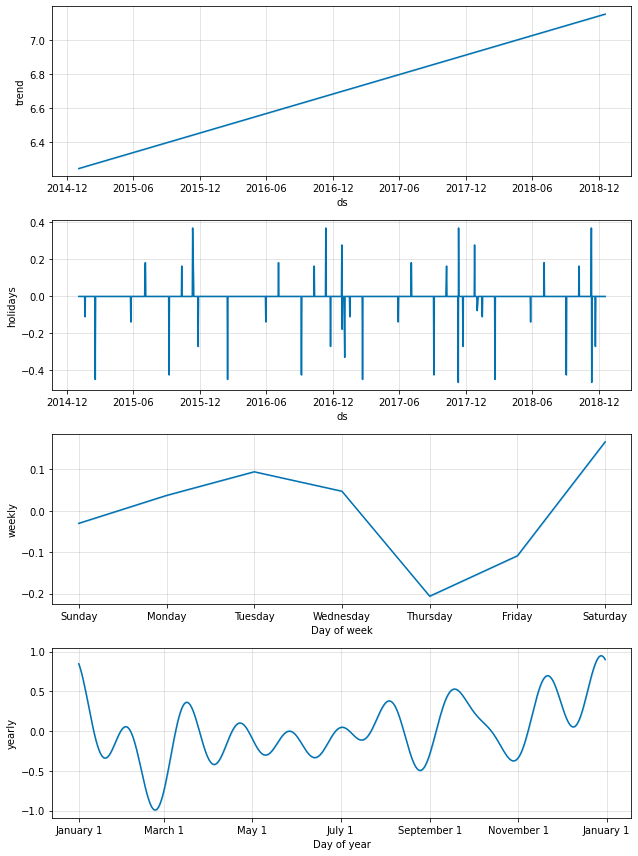

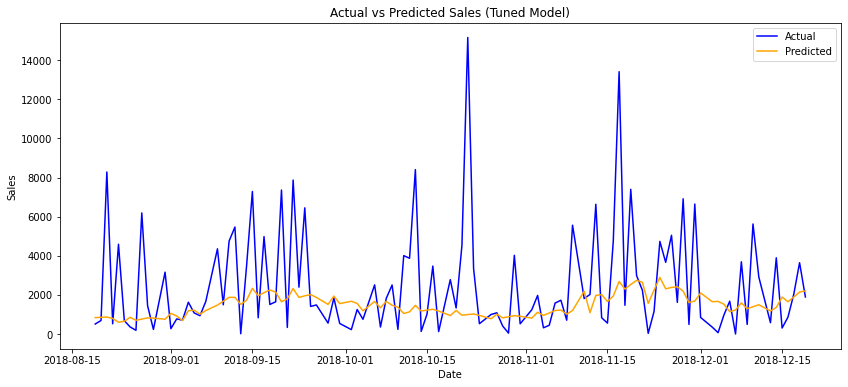

In [31]:
model.plot(forecast)
plt.title("Sales Forecast (Tuned Prophet Model)")
plt.show()

model.plot_components(forecast)
plt.show()

plt.figure(figsize=(14,6))
plt.plot(preds['ds'], preds['y_exp'], label='Actual', color='blue')
plt.plot(preds['ds'], preds['yhat_exp'], label='Predicted', color='orange')
plt.title("Actual vs Predicted Sales (Tuned Model)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


> MAE dropped further ( 1766.01 →  best so far )

> RMSE rose slightly (2805.10),  the model’s doing even better on average but still underfits spikes.